In [1]:


# using Pkg
# Pkg.add("BenchmarkTools")
# Pkg.add("Distributions")
# Pkg.add("CxxWrap")
# Pkg.add("JLD")
# Pkg.add("ImageIO")
# Pkg.add("CircularArrays")
# Pkg.add("OffsetArrays")
# Pkg.add("TensorOperations")
# Pkg.add("TensorCast")
# Pkg.add("Tullio")
# Pkg.add("DiffEqOperators")
# Pkg.add("BandedMatrices")
# Pkg.add("PyPlot")
# Pkg.add("Plots")
# Pkg.add("FFTW")
# Pkg.add("SciPy")
# Pkg.add("GR")
# Pkg.add("Statistics")
# Pkg.add("Formatting")

import GR
using BenchmarkTools
using Distributions
using Random
using Plots
using PyCall
using PyPlot
#using Images
using CircularArrays
using CxxWrap
using FFTW
using SciPy
using JLD
using Statistics
using Formatting
stats = pyimport("scipy.stats")
np = pyimport("numpy")
cv2 = pyimport("cv2")



PyObject <module 'cv2' from '/usr/lib/python3/dist-packages/cv2.cpython-38-x86_64-linux-gnu.so'>

In [2]:
function Laplacian_2D!(P₁,P₂,A₁,A₂,Δx)
    B₁ = CircularArrays.CircularArray(A₁);
    B₂ = CircularArrays.CircularArray(A₂);
    Threads.@threads for 😄 ∈ CartesianIndices(P₁)
        (i,j) = Tuple(😄)
        P₁[i,j] = @fastmath (-B₁[i+2,j] + 16B₁[i+1,j] 
            + 16B₁[i-1,j] -B₁[i-2,j] 
            -B₁[i,j+2] + 16B₁[i,j+1] 
            + 16B₁[i,j-1] -B₁[i,j-2] 
            - 60B₁[i,j]) /(12Δx^2);
        P₂[i,j] = @fastmath (-B₂[i+2,j] + 16B₂[i+1,j] 
            + 16B₂[i-1,j] -B₂[i-2,j] 
            -B₂[i,j+2] + 16B₂[i,j+1] 
            + 16B₂[i,j-1] -B₂[i,j-2] 
            - 60B₂[i,j]) /(12Δx^2);  
    end
    return nothing
end

function NLaplacian_2D!(P₁,P₂,B₁,B₂,Δx)
    N = length(P₁[:,1])
    M = length(P₁[1,:])

    for i ∈ 2:N-1
        for j ∈ 2:M-1
            P₁[i,j] = @fastmath (B₁[i+1,j] 
                + B₁[i-1,j] 
                + B₁[i,j+1] 
                + B₁[i,j-1]  
                - 4B₁[i,j]) /(Δx^2);
            P₂[i,j] = @fastmath (B₂[i+1,j] 
                + B₂[i-1,j] 
                + B₂[i,j+1] 
                + B₂[i,j-1] 
                - 4B₂[i,j]) /(Δx^2);  
         end
    end


    for i ∈ 2:N-1
        P₁[i,1] = (B₁[i-1,1] + B₁[i+1,1] + 2B₁[i,2] - 4B₁[i,1])/(Δx)^2
        P₁[i,M] = (B₁[i-1,M] + B₁[i+1,M] + 2B₁[i,M-1] - 4B₁[i,M])/(Δx)^2
        P₂[i,1] = (B₂[i-1,1] + B₂[i+1,1] + 2B₂[i,2] - 4B₂[i,1])/(Δx)^2
        P₂[i,M] = (B₂[i-1,M] + B₂[i+1,M] + 2B₂[i,M-1] - 4B₂[i,M])/(Δx)^2
    end


    for j ∈ 2:M-1
        P₁[1,j] = (B₁[1,j-1] + B₁[1,j+1] + 2B₁[2,j] - 4B₁[1,j])/(Δx)^2
        P₁[N,j] = (B₁[N,j-1] + B₁[N,j+1] + 2B₁[N-1,j] - 4B₁[N,j])/(Δx)^2
        P₁[1,j] = (B₂[1,j-1] + B₂[1,j+1] + 2B₂[2,j] - 4B₂[1,j])/(Δx)^2
        P₁[N,j] = (B₂[N,j-1] + B₂[N,j+1] + 2B₂[N-1,j] - 4B₂[N,j])/(Δx)^2
    end

    P₁[1,1] = (2B₁[2,1] + 2B₁[1,2] - 4B₁[1,1])/(Δx)^2


    P₁[N,1] = (2B₁[N-1,1] + 2B₁[N,2] - 4B₁[N,1])/(Δx)^2

 

    P₁[1,M] = (2B₁[1,M-1] + 2B₁[2,M] - 4B₁[1,M])/(Δx)^2 



    P₁[N,M] = (2B₁[N,M-1] + 2B₁[N-1,M] - 4B₁[N,M])/(Δx)^2


   
    P₂[1,1] = (2B₂[2,1] + 2B₂[1,2] - 4B₂[1,1])/(Δx)^2

    
    P₂[N,1] = (2B₂[N-1,1] + 2B₂[N,2] - 4B₂[N,1])/(Δx)^2

    
    P₂[1,M] = (2B₂[1,M-1] + 2B₂[2,M] - 4B₂[1,M])/(Δx)^2 

    
    P₂[N,M] = (2B₂[N,M-1] + 2B₂[N-1,M] - 4B₂[N,M])/(Δx)^2


    return nothing
end




function Make_Oscillon!(angle,A,N,σ)
    for i ∈ 1:N
        for j ∈ 1:N
            x = abs(i - (N+1)/2)
            y = abs(j - (N+1)/2)
            angle[i,j] = A/cosh(sqrt(x^2 + y^2)/σ)
        end
    end
    return nothing
end

function Make_WOscillon!(angle,A,N,σ)
    B = rand(Normal(1,1e-1),N,N)
    for i ∈ 1:N
        for j ∈ 1:N
            x = abs(i - (N+1)/2)
            y = abs(j - (N+1)/2)
            angle[i,j] = A/cosh(sqrt(x^2 + y^2)/σ) * B[i,j]
        end
    end
    return nothing
end

function Anti_string!(A₁,A₂,N,Σ,varx,vary)
    for i ∈ 1:N 
        for j ∈ 1:N             
            xclose = i - varx
            yclose = vary - j
            xfar = i - (N+1)/2
            yfar = (N+1)/2 - j
            t = exp(-20(xclose^2 + yclose^2)/N^2)
            x = xclose*t + (1-t)*xfar
            y = yclose*t + (1-t)*yfar
            
            θ = angle(x + y*im)
            A₁[i,j] = Σ*cos(θ)
            A₂[i,j] = Σ*sin(θ)
        end
    end
    return nothing
end

function Clock_string!(A_1,A_2,N,b,varx,vary)
    for i in 1:N 
        for j in 1:N 
            xclose = i - varx
            yclose = vary - j
            xfar = i - (N+1)/2
            yfar = (N+1)/2 - j
            t = exp(-20(xclose^2 + yclose^2)/N^2)
            x = xclose*t + (1-t)*xfar
            y = yclose*t + (1-t)*yfar
            
            theta = angle(x - y*im)
            A_1[i,j] = b*cos(theta) 
            A_2[i,j] = b*sin(theta) 
        end
    end
    return nothing
end



function Anti_2string!(A₁,A₂,N,Σ)
    for i ∈ 1:N 
        for j ∈ 1:N             
            x = i - (N+1)/2
            y = (N+1)/2 - j
            t = exp(-1*(x^2 + y^2)/N^2)
            
            θ = angle(x + y*im)*t
            A₁[i,j] = Σ*cos(θ) 
            A₂[i,j] = Σ*sin(θ) 
        end
    end
    return nothing
end


function Clock_2string!(A₁,A₂,N,Σ)
    for i ∈ 1:N 
        for j ∈ 1:N 
            x = i - (N+1)/2
            y = (N+1)/2 - j
            t = exp(-1*(x^2 + y^2)/N^2)
            
            θ = angle(x - y*im)*t
            A₁[i,j] = Σ*cos(θ) 
            A₂[i,j] = Σ*sin(θ) 
        end
    end
    return nothing
end

function slot!(A,B,a,b)
    A = CircularArrays.CircularArray(A)
    M = length(B[:,1])
    N = length(B[1,:])
    for i ∈ 1:M
        for j ∈ 1:N
            A[a+i-Int(M/2),b+j-Int(N/2)] = B[i,j]
        end
    end
    return nothing
end


function Cores_2D!(N,angle,thr)
    s = []
    count = 0
    accept = 0.5 - 0.5*thr/100
    for 😄 ∈ 1:(N-1)
        for 🥪 ∈ 1:(N-1)
            norm₁ = (angle[😄,🥪] + π)/(2π)
            norm₂ = (angle[😄+1,🥪] + π)/(2π)
            norm₃ = (angle[😄+1,🥪+1] + π)/(2π)
            norm₄ = (angle[😄,🥪+1] + π)/(2π)

            θ₁ = min(abs(norm₂ - norm₁), 1 - abs(norm₂ - norm₁))
            θ₂ = min(abs(norm₃ - norm₂), 1 - abs(norm₃ - norm₂))
            θ₃ = min(abs(norm₄ - norm₃), 1 - abs(norm₄ - norm₃))
            θₛ = θ₁ + θ₂ + θ₃

            if θₛ > accept 
                append!(s,[[😄,🥪]])
            end
        end
    end

    if length(s) > 0
        for 🇸🇦 ∈ 1:(length(s)-1)
  
            diffᵣ = s[🇸🇦 + 1][1] - s[🇸🇦][1]
            diffₛ = s[🇸🇦 + 1][2] - s[🇸🇦][2]

            if diffᵣ == 0 && diffₛ == 1
                count += 1
            end
            if diffᵣ == 1 && diffₛ == 0
                count += 1
            end
        end
    end

    num = length(s) - count

    return num
end


function setting!(moo)
    @inbounds Threads.@threads for t in eachindex(moo)
        if moo[t] > 1
            moo[t] = 1
        end
    end
    return nothing
end

function mooing!(moo,A₁,A₂)
    @inbounds Threads.@threads for 😄 ∈ CartesianIndices(moo)
        (i,j) = Tuple(😄)
        @fastmath moo[i,j] = sqrt(A₁[i,j]^2 + A₂[i,j]^2)
    end
    return nothing
end


function angler!(angle,A₁,A₂)
    @inbounds Threads.@threads for 😄 ∈ CartesianIndices(angle)
        (i,j) = Tuple(😄)
        angle[i,j] = @fastmath atan(A₂[i,j],A₁[i,j]);
    end
    return nothing
end

function meshgrid(xin,yin)
    nx=length(xin)
    ny=length(yin)
    xout=zeros(ny,nx)
    yout=zeros(ny,nx)
    for jx=1:nx
        for ix=1:ny
            xout[ix,jx]=xin[jx]
            yout[ix,jx]=yin[ix]
        end
    end
    return (x=xout, y=yout)
end


function minmax(A)
    lower = minimum(minimum.(A))
    upper = maximum(maximum.(A))
    return lower,upper
end

minmax (generic function with 1 method)

In [3]:
function PQfupdate_2D!(F₁,F₂,M₁,M₂,C₁,C₂,A₁,A₂,Ȧ₁,Ȧ₂,η,λ,fₐ)
    @inbounds Threads.@threads for 😄 ∈ CartesianIndices(F₁)
        (i,j) = Tuple(😄)
        F₁[i,j] = @fastmath M₁[i,j] - λ * C₁[i,j] * η^2 * (A₁[i,j]^2 .+ A₂[i,j]^2 .- 1) - λ * C₁[i,j]*8.4e5 * 1e12/(3fₐ) - 2/η * Ȧ₁[i,j];
        F₂[i,j] = @fastmath M₂[i,j] - λ * C₂[i,j] * η^2 * (A₁[i,j]^2 .+ A₂[i,j]^2 .- 1) - λ * C₂[i,j]*8.4e5 * 1e12/(3fₐ) - 2/η * Ȧ₂[i,j];
    end
    return nothing
end


function PQAupdate_2D!(A₁,A₂,Δt,Ȧ₁,Ȧ₂,F₁,F₂)
    @inbounds Threads.@threads for 😄 ∈ CartesianIndices(A₁)
        (i,j) = Tuple(😄)
        A₁[i,j] = @fastmath A₁[i,j] .+ Δt .* (Ȧ₁[i,j] .+ 0.5Δt .* F₁[i,j])
        A₂[i,j] = @fastmath A₂[i,j] .+ Δt .* (Ȧ₂[i,j] .+ 0.5Δt .* F₂[i,j])
    end
    return nothing
end


function PQvelupdate_2D!(Ȧ₁,Ȧ₂,Δt,F₁,F₂,M₁,M₂,C₁,C₂,A₁,A₂,η,λ,fₐ)
    @inbounds Threads.@threads for 😄 ∈ CartesianIndices(Ȧ₁)
        (i,j) = Tuple(😄)
        Ȧ₁[i,j] = @fastmath Ȧ₁[i,j] .+ 0.5Δt .* (F₁[i,j] .+ M₁[i,j] - λ * C₁[i,j] * η^2 * (A₁[i,j]^2 .+ A₂[i,j]^2 .- 1) - λ * C₁[i,j]*8.4e5 * 1e12/(3fₐ) - 2/η * Ȧ₁[i,j]);
        Ȧ₂[i,j] = @fastmath Ȧ₂[i,j] .+ 0.5Δt .* (F₂[i,j] .+ M₂[i,j] - λ * C₂[i,j] * η^2 * (A₁[i,j]^2 .+ A₂[i,j]^2 .- 1) - λ * C₂[i,j]*8.4e5 * 1e12/(3fₐ) - 2/η * Ȧ₂[i,j]);
    end
    return nothing
end

function PQupdate_2D!(A₁,A₂,Ȧ₁,Ȧ₂,M₁,M₂,F₁,F₂,Δx,Δt,time,fₐ)

    #F₁ .= M₁ .- a.^β .* λ .* A₁ .*(A₁.^2 .+ A₂.^2 .- η.^2) .- α .* © .* Ȧ₁ ./time
    #F₂ .= M₂ .- a.^β .* λ .* A₂ .*(A₁.^2 .+ A₂.^2 .- η.^2) .- α .* © .* Ȧ₂ ./time

    PQfupdate_2D!(F₁,F₂,M₁,M₂,A₁,A₂,A₁,A₂,Ȧ₁,Ȧ₂,time,1,fₐ)

    #A₁ .= A₁ .+ Δt .* (Ȧ₁ .+ 0.5Δt .* F₁)
    #A₂ .= A₂ .+ Δt .* (Ȧ₂ .+ 0.5Δt .* F₂)

    PQAupdate_2D!(A₁,A₂,Δt,Ȧ₁,Ȧ₂,F₁,F₂)

    Laplacian_2D!(M₁,M₂,A₁,A₂,Δx)

    #Ȧ₁ .= Ȧ₁ .+ 0.5Δt .* (F₁ .+ M₁ .- a₁.^β .* λ .* A₁ .* (A₁.^2 .+ A₂.^2 .- η.^2) .- α .* © .* Ȧ₁ ./ (time + Δt))
    #Ȧ₂ .= Ȧ₂ .+ 0.5Δt .* (F₂ .+ M₂ .- a₁.^β .* λ .* A₂ .* (A₁.^2 .+ A₂.^2 .- η.^2) .- α .* © .* Ȧ₂ ./ (time + Δt))

    
    PQvelupdate_2D!(Ȧ₁,Ȧ₂,Δt,F₁,F₂,M₁,M₂,A₁,A₂,A₁,A₂,time + Δt,1,fₐ)

    return nothing
end



PQupdate_2D! (generic function with 1 method)

In [4]:
function EQCDfupdate_2D!(F₁,F₂,M₁,M₂,C₁,C₂,A₁,A₂,Ȧ₁,Ȧ₂,η,λ,ηₓ,n)
    @inbounds Threads.@threads for 😄 ∈ CartesianIndices(F₁)
        (i,j) = Tuple(😄)
        F₁[i,j] = @fastmath M₁[i,j] - λ * C₁[i,j] * η^2 * (A₁[i,j]^2 .+ A₂[i,j]^2 .- 1) + ηₓ^n *η^2 * C₂[i,j]^2/((A₁[i,j]^2 .+ A₂[i,j]^2)^1.5) - 2/η * Ȧ₁[i,j];
        F₂[i,j] = @fastmath M₂[i,j] - λ * C₂[i,j] * η^2 * (A₁[i,j]^2 .+ A₂[i,j]^2 .- 1) - ηₓ^n *η^2 * C₁[i,j]*C₂[i,j]/((A₁[i,j]^2 .+ A₂[i,j]^2)^1.5) - 2/η * Ȧ₂[i,j];
    end
    return nothing
end


function EQCDAupdate_2D!(A₁,A₂,Δt,Ȧ₁,Ȧ₂,F₁,F₂)
    @inbounds Threads.@threads for 😄 ∈ CartesianIndices(A₁)
        (i,j) = Tuple(😄)
        A₁[i,j] = @fastmath A₁[i,j] .+ Δt .* (Ȧ₁[i,j] .+ 0.5Δt .* F₁[i,j])
        A₂[i,j] = @fastmath A₂[i,j] .+ Δt .* (Ȧ₂[i,j] .+ 0.5Δt .* F₂[i,j])
    end
    return nothing
end


function EQCDvelupdate_2D!(Ȧ₁,Ȧ₂,Δt,F₁,F₂,M₁,M₂,C₁,C₂,A₁,A₂,η,λ,ηₓ,n)
    @inbounds Threads.@threads for 😄 ∈ CartesianIndices(Ȧ₁)
        (i,j) = Tuple(😄)
        Ȧ₁[i,j] = @fastmath Ȧ₁[i,j] .+ 0.5Δt .* (F₁[i,j] .+ M₁[i,j] - λ * C₁[i,j] * η^2 * (A₁[i,j]^2 .+ A₂[i,j]^2 .- 1) + ηₓ^n *η^2 * C₂[i,j]^2/((A₁[i,j]^2 .+ A₂[i,j]^2)^1.5) - 2/η * Ȧ₁[i,j])
        Ȧ₂[i,j] = @fastmath Ȧ₂[i,j] .+ 0.5Δt .* (F₂[i,j] .+ M₂[i,j] - λ * C₂[i,j] * η^2 * (A₁[i,j]^2 .+ A₂[i,j]^2 .- 1) - ηₓ^n *η^2 * C₁[i,j]*C₂[i,j]/((A₁[i,j]^2 .+ A₂[i,j]^2)^1.5) - 2/η * Ȧ₂[i,j])
    end
    return nothing
end


function EQCDupdate_2D!(A₁,A₂,Ȧ₁,Ȧ₂,M₁,M₂,F₁,F₂,Δx,Δt,time,fₐ,r,s,n)



    #λ = (fₐ/mass(fₐ))^2;

    λᵪ = [1024 1448 3072 3584 5504 1e-4 1e5];
    #ηₓ,η = ηtime(time,fₐ);
    λ = λᵪ[r]

    ηᵪ = [2.8 3 3.2 3.4 3.6 0 6 1]
    ηₓ = ηᵪ[s]

    if time < ηₓ
        ηₓ = time
    end
    

    #F₁ .= M₁ .- a.^β .* λ .* A₁ .*(A₁.^2 .+ A₂.^2 .- η.^2) .- α .* © .* Ȧ₁ ./time
    #F₂ .= M₂ .- a.^β .* λ .* A₂ .*(A₁.^2 .+ A₂.^2 .- η.^2) .- α .* © .* Ȧ₂ ./time

    EQCDfupdate_2D!(F₁,F₂,M₁,M₂,A₁,A₂,A₁,A₂,Ȧ₁,Ȧ₂,time,λ,ηₓ,n)

    #A₁ .= A₁ .+ Δt .* (Ȧ₁ .+ 0.5Δt .* F₁)
    #A₂ .= A₂ .+ Δt .* (Ȧ₂ .+ 0.5Δt .* F₂)

    EQCDAupdate_2D!(A₁,A₂,Δt,Ȧ₁,Ȧ₂,F₁,F₂)
    
    Laplacian_2D!(M₁,M₂,A₁,A₂,Δx)

    #Ȧ₁ .= Ȧ₁ .+ 0.5Δt .* (F₁ .+ M₁ .- a₁.^β .* λ .* A₁ .* (A₁.^2 .+ A₂.^2 .- η.^2) .- α .* © .* Ȧ₁ ./ (time + Δt))
    #Ȧ₂ .= Ȧ₂ .+ 0.5Δt .* (F₂ .+ M₂ .- a₁.^β .* λ .* A₂ .* (A₁.^2 .+ A₂.^2 .- η.^2) .- α .* © .* Ȧ₂ ./ (time + Δt))

    #ηₓ,η = ηtime(time+Δt,fₐ);

    EQCDvelupdate_2D!(Ȧ₁,Ȧ₂,Δt,F₁,F₂,M₁,M₂,A₁,A₂,A₁,A₂, time + Δt,λ,ηₓ,n)

    return nothing
end


function NEQCDupdate_2D!(A₁,A₂,Ȧ₁,Ȧ₂,M₁,M₂,F₁,F₂,Δx,Δt,time,fₐ,r,s,n)



    #λ = (fₐ/mass(fₐ))^2;

    λᵪ = [1024 1448 3072 3584 5504 1e-4 1e5];
    #ηₓ,η = ηtime(time,fₐ);
    λ = λᵪ[r]

    ηᵪ = [2.8 3 3.2 3.4 3.6 0 6 1]
    ηₓ = ηᵪ[s]

    if time < ηₓ
        ηₓ = time
    end
    

    #F₁ .= M₁ .- a.^β .* λ .* A₁ .*(A₁.^2 .+ A₂.^2 .- η.^2) .- α .* © .* Ȧ₁ ./time
    #F₂ .= M₂ .- a.^β .* λ .* A₂ .*(A₁.^2 .+ A₂.^2 .- η.^2) .- α .* © .* Ȧ₂ ./time

    EQCDfupdate_2D!(F₁,F₂,M₁,M₂,A₁,A₂,A₁,A₂,Ȧ₁,Ȧ₂,time,λ,ηₓ,n)

    #A₁ .= A₁ .+ Δt .* (Ȧ₁ .+ 0.5Δt .* F₁)
    #A₂ .= A₂ .+ Δt .* (Ȧ₂ .+ 0.5Δt .* F₂)

    EQCDAupdate_2D!(A₁,A₂,Δt,Ȧ₁,Ȧ₂,F₁,F₂)
    
    NLaplacian_2D!(M₁,M₂,A₁,A₂,Δx)

    #Ȧ₁ .= Ȧ₁ .+ 0.5Δt .* (F₁ .+ M₁ .- a₁.^β .* λ .* A₁ .* (A₁.^2 .+ A₂.^2 .- η.^2) .- α .* © .* Ȧ₁ ./ (time + Δt))
    #Ȧ₂ .= Ȧ₂ .+ 0.5Δt .* (F₂ .+ M₂ .- a₁.^β .* λ .* A₂ .* (A₁.^2 .+ A₂.^2 .- η.^2) .- α .* © .* Ȧ₂ ./ (time + Δt))

    #ηₓ,η = ηtime(time+Δt,fₐ);

    EQCDvelupdate_2D!(Ȧ₁,Ȧ₂,Δt,F₁,F₂,M₁,M₂,A₁,A₂,A₁,A₂, time + Δt,λ,ηₓ,n)

    return nothing
end

NEQCDupdate_2D! (generic function with 1 method)

In [5]:
function LLaplacian_2D!(P,A,Δx)
    B = CircularArray(A);
    Threads.@threads for 😄 ∈ CartesianIndices(P)
        (i,j) = Tuple(😄)
        P[i,j] = @fastmath (-B[i+2,j] + 16B[i+1,j] 
            + 16B[i-1,j] -B[i-2,j] 
            -B[i,j+2] + 16B[i,j+1] 
            + 16B[i,j-1] -B[i,j-2] 
            - 60B[i,j]) /(12Δx^2);
    end
    return nothing
end


function Lfupdate_2D!(F,M,A,Ȧ,η,ηₓ,n)
    @inbounds Threads.@threads for 😄 ∈ CartesianIndices(F)
        (i,j) = Tuple(😄)
        F[i,j] = @fastmath M[i,j] - ηₓ^n * η^2 * sin(A[i,j]) - 2/η * Ȧ[i,j];
    end
    return nothing
end


function LAupdate_2D!(A,Δt,Ȧ,F)
    @inbounds Threads.@threads for 😄 ∈ CartesianIndices(A)
        (i,j) = Tuple(😄)
        A[i,j] = @fastmath A[i,j] .+ Δt .* (Ȧ[i,j] .+ 0.5Δt .* F[i,j])
    end
    return nothing
end


function Lvelupdate_2D!(Ȧ,Δt,F,M,A,η,ηₓ,n)
    @inbounds Threads.@threads for 😄 ∈ CartesianIndices(Ȧ)
        (i,j) = Tuple(😄)
        Ȧ[i,j] = @fastmath Ȧ[i,j] .+ 0.5Δt .* (F[i,j] .+ M[i,j] - ηₓ^n * η^2 * sin(A[i,j]) - 2/η * Ȧ[i,j])
    end
    return nothing
end


function Lupdate_2D!(A,Ȧ,M,F,Δx,Δt,time,fₐ,s,n)

    #ηₓ,η = Lηtime(time,fₐ);


    ηᵪ = [2.8 3 3.2 3.4 3.6 0 6 1]
    ηₓ = ηᵪ[s]

    if time < ηₓ
        ηₓ = time
    end

    #F₁ .= M₁ .- a.^β .* λ .* A₁ .*(A₁.^2 .+ A₂.^2 .- η.^2) .- α .* © .* Ȧ₁ ./time
    #F₂ .= M₂ .- a.^β .* λ .* A₂ .*(A₁.^2 .+ A₂.^2 .- η.^2) .- α .* © .* Ȧ₂ ./time

    Lfupdate_2D!(F,M,A,Ȧ,time,ηₓ,n)

    #A₁ .= A₁ .+ Δt .* (Ȧ₁ .+ 0.5Δt .* F₁)
    #A₂ .= A₂ .+ Δt .* (Ȧ₂ .+ 0.5Δt .* F₂)

    LAupdate_2D!(A,Δt,Ȧ,F)

    LLaplacian_2D!(M,A,Δx)

    #Ȧ₁ .= Ȧ₁ .+ 0.5Δt .* (F₁ .+ M₁ .- a₁.^β .* λ .* A₁ .* (A₁.^2 .+ A₂.^2 .- η.^2) .- α .* © .* Ȧ₁ ./ (time + Δt))
    #Ȧ₂ .= Ȧ₂ .+ 0.5Δt .* (F₂ .+ M₂ .- a₁.^β .* λ .* A₂ .* (A₁.^2 .+ A₂.^2 .- η.^2) .- α .* © .* Ȧ₂ ./ (time + Δt))

    #ηₓ,η = Lηtime(time+Δt,fₐ)

    Lvelupdate_2D!(Ȧ,Δt,F,M,A,time + Δt,ηₓ,n)

    return nothing
end


Lupdate_2D! (generic function with 1 method)

In [10]:
function Srun_2D!(n,N,t₁,A₁,A₂,Ȧ₁,Ȧ₂,Δx,Δt,fₐ,i,r,s,repeats,cont,low,B,aang,poggers,cap,pic)
    
    col = length(A₁[:,1])
    row = length(A₁[1,:])

    M₁ = zeros(col,row);
    M₂ = zeros(col,row);

    F₁ = zeros(col,row);
    F₂ = zeros(col,row);

    Laplacian_2D!(M₁,M₂,A₁,A₂,Δx)

    moo = zeros(col,row);
    angll = zeros(col,row);
    angler!(angll,A₁,A₂);

    k_freqy = fftfreq(col)*col
    k_freqx = fftfreq(row)*row
    kx,ky = meshgrid(k_freqx,k_freqy)

    knrm = sqrt.( kx.^2 + ky.^2)
    knrm = collect(Iterators.flatten(knrm))

    mdr = maximum([col,row])
    
    kbins = range(0.5, mdr/2+1, step = 1)
    kvals = 0.5 * (kbins[2:end] + kbins[1:end-1])
    
    x = cap

    tracker = []
    cores = []
    thr = 1
    lo = low
    strng = 1
    mng = 0
    

    saxion = []
    axion = []
    axenergy = []
    axionmax = []
    axionmin = []
    
    Ȧ = zeros(col,row)

    Ȧ .= (Ȧ₂ .*  A₁ .- Ȧ₁ .* A₂)./(A₁.^2 .+ A₂.^2)

    M = zeros(col,row);

    F = zeros(col,row);

    LLaplacian_2D!(M,angll,Δx)
    
    tim = t₁
    
    ay,az = minmax(angll)
    
    
    if aang != 0
        Ȧ = B
        strng = 0
        mng = 2
        angll = aang
        ay = 0
        az = 0
    end
    
    
    for 🥪 ∈ 1+cont:repeats+cont
        

        while tim < 0.2*🥪 + t₁
        #while strng != 0
            
            if az ≥ 1 && ay ≤ -1


                tim = round(tim,digits = 7);
                if lo % x == 0

                    mooing!(moo,A₁,A₂);
                    #println(moo[1,1])
                    #setting!(moo);
                    angler!(angll,A₁,A₂);
                    
                    

                    strng = Cores_2D!(N,angll,thr)
                    
          
                    
                    append!(tracker,tim)
                    append!(cores,strng)


                    f_image = FFTW.fft(moo)
                    f_images = (abs.(f_image)).^2
                    f_images = collect(Iterators.flatten(f_images))

                    Abin,_,_ = stats.binned_statistic(knrm,f_images,statistic = "mean",bins = kbins)
                    Abin = π* Abin.* (kbins[2:end].^2 - kbins[1:end-1].^2)



                    append!(saxion,[Abin])

                    f_image = FFTW.fft(angll)
                    f_images = (abs.(f_image)).^2
                    f_images = collect(Iterators.flatten(f_images))

                    Abins,_,_ = stats.binned_statistic(knrm,f_images,statistic = "mean",bins = kbins)
                    Abins = π* Abins.* (kbins[2:end].^2 - kbins[1:end-1].^2)

                    append!(axion,[Abins])
                    
                    Ȧ .= (Ȧ₂ .*  A₁ .- Ȧ₁ .* A₂)./(A₁.^2 .+ A₂.^2)
                    ρ = Ȧ.^2
                    
                    rho = mean(ρ)
                    
                    amax = maximum((log.(ρ/rho)))
                    amin = minimum((log.(ρ/rho)))
                    
                    append!(axionmax,amax)
                    append!(axionmin,amin)
                    
                    PyPlot.imsave("QCDTOWN/String/Den/"*string(i)*"/"*lpad( string(trunc(Int, pic + lo/x )) ,3,"0")*".png",(log.(ρ/rho)), vmin = 0,vmax = 6,cmap = "inferno")


                    f_image = FFTW.fft( ρ .* fₐ^2)
                    f_images = (abs.(f_image)).^2
                    f_images = collect(Iterators.flatten(f_images))

                    Abint,_,_ = stats.binned_statistic(knrm,f_images,statistic = "mean",bins = kbins)
                    Abint = π* Abint.* (kbins[2:end].^2 - kbins[1:end-1].^2)

                    append!(axenergy,[Abint])


                    
                    
                    

                    PyPlot.imsave("QCDTOWN/String/Ang/"*string(i)*"/"*lpad( string(trunc(Int, pic+ lo/x )) ,3,"0")*".png",angll,vmin=-π,vmax = π,cmap = "twilight")
                    
                    ay,az = minmax(angll)

                end
                if tim < 100
                
                    EQCDupdate_2D!(A₁,A₂,Ȧ₁,Ȧ₂,M₁,M₂,F₁,F₂,Δx,Δt,tim,fₐ,r,s,poggers)
                    tim = tim + Δt
                    
                else
                    EQCDupdate_2D!(A₁,A₂,Ȧ₁,Ȧ₂,M₁,M₂,F₁,F₂,Δx,Δt*(3/tim)^3.34,tim,fₐ,r,s,poggers)
                    tim = tim + Δt*(3/tim)^3.34
                    
                end
                lo += 1
                
                


                
            else
                
                if mng == 0
                    Ȧ = zeros(col,row)

                    Ȧ .= (Ȧ₂ .*  A₁ .- Ȧ₁ .* A₂)./(A₁.^2 .+ A₂.^2)

                    M = zeros(col,row);

                    F = zeros(col,row);

                    LLaplacian_2D!(M,angll,Δx)
                elseif mng == 2
                    M = zeros(col,row);

                    F = zeros(col,row);

                    LLaplacian_2D!(M,angll,Δx)
                end


                tim = round(tim,digits = 7);
                if lo % x == 0


                    strng = Cores_2D!(N,angll,thr)

        

                    append!(tracker,tim)
                    append!(cores,strng)




                    f_image = FFTW.fft(angll)
                    f_images = (abs.(f_image)).^2
                    f_images = collect(Iterators.flatten(f_images))

                    Abins,_,_ = stats.binned_statistic(knrm,f_images,statistic = "mean",bins = kbins)
                    Abins = π* Abins.* (kbins[2:end].^2 - kbins[1:end-1].^2)


                    append!(axion,[Abins])
                    
                    
                    ρ = Ȧ.^2
                    rho = mean(ρ)
                    
                    
                    amax = maximum((log.(ρ/rho)))
                    amin = minimum((log.(ρ/rho)))
                    
                    append!(axionmax,amax)
                    append!(axionmin,amin)
                    
                    
                    PyPlot.imsave("QCDTOWN/String/Den/"*string(i)*"/"*lpad( string(trunc(Int,pic + lo/x )) ,3,"0")*".png",(log.(ρ/rho)),vmin = 0,vmax = 6,cmap = "inferno")


                    f_image = FFTW.fft( ρ .* fₐ^2)
                    f_images = (abs.(f_image)).^2
                    f_images = collect(Iterators.flatten(f_images))

                    Abint,_,_ = stats.binned_statistic(knrm,f_images,statistic = "mean",bins = kbins)
                    Abint = π* Abint.* (kbins[2:end].^2 - kbins[1:end-1].^2)

                    append!(axenergy,[Abint])





                    

                    PyPlot.imsave("QCDTOWN/String/Ang/"*string(i)*"/"*lpad( string(trunc(Int,pic + lo/x )) ,3,"0")*".png",angll,vmin=-π,vmax = π,cmap = "twilight")
                    
                    ay,az = minmax(angll)

                end
                
                if tim < 100
                    Lupdate_2D!(angll,Ȧ,M,F,Δx,Δt,tim,fₐ,s,poggers)
                    tim = tim + Δt
#                 elseif tim < 5
#                     Lupdate_2D!(angll,Ȧ,M,F,Δx,Δt*(3/tim)^3.34,tim,fₐ,s,poggers)
#                     tim = tim + Δt*(5/tim)^3.34
                else
                    Lupdate_2D!(angll,Ȧ,M,F,Δx,Δt*(10/tim)^3.34,tim,fₐ,s,poggers)
                    tim = tim + Δt*(10/tim)^3.34
                end
                
                lo += 1
   
                mng = 1

               
            end
           

        end

        save("QCDTOWN/String/Saving/Box"*string(n)*string(🥪)*string(i)*".jld", "Real", A₁,"Imaginary",A₂,"Realvel",Ȧ₁,"RealIm",Ȧ₂,"angle",angll,"AngVel",Ȧ)
        save("QCDTOWN/String/Saving/MinMax"*string(n)*string(🥪)*string(i)*".jld", "max", axionmax,"min",axionmin)



        save("QCDTOWN/String/Saving/Strings"*string(n)*string(🥪)*string(i)*".jld","time",tracker,"number",cores,"lo",lo)
        save("QCDTOWN/String/Saving/FFT"*string(n)*string(🥪)*string(i)*".jld","saxion",saxion,"axion",axion,"axenergy",axenergy)


        println(tim)
 

        
    end


    

    return nothing
end

Srun_2D! (generic function with 1 method)

In [7]:
function Orun_2D!(n,N,t₁,A₁,A₂,Ȧ₁,Ȧ₂,Δx,Δt,fₐ,i,r,s,repeats,cont,low,B,aang,poggers,cap,pic)


    
    col = length(A₁[:,1])
    row = length(A₁[1,:])

    M₁ = zeros(col,row);
    M₂ = zeros(col,row);

    F₁ = zeros(col,row);
    F₂ = zeros(col,row);
    
    ∇a = zeros(col,row);

    Laplacian_2D!(M₁,M₂,A₁,A₂,Δx)

    moo = zeros(col,row);
    angll = zeros(col,row);
    angler!(angll,A₁,A₂);

    k_freqy = fftfreq(col)*col
    k_freqx = fftfreq(row)*row
    kx,ky = meshgrid(k_freqx,k_freqy)

    knrm = sqrt.( kx.^2 + ky.^2)
    knrm = collect(Iterators.flatten(knrm))

    mdr = maximum([col,row])
    
    kbins = range(0.5, mdr/2+1, step = 1)
    kvals = 0.5 * (kbins[2:end] + kbins[1:end-1])
    
    x = cap

    tracker = []
    cores = []
    thr = 1
    lo = low
    strng = 1
    mng = 0
    
    timguys = [2.8 3 3.2 3.4 3.6 0 6 1]

    saxion = []
    axion = []
    axenergy = []
    axionmax = []
    axionmin = []
    Fmax = []
    Fmin = []
    Fmed = []
    
    Ȧ = zeros(col,row)

    Ȧ .= (Ȧ₂ .*  A₁ .- Ȧ₁ .* A₂)./(A₁.^2 .+ A₂.^2)

    M = zeros(col,row);

    F = zeros(col,row);

    LLaplacian_2D!(M,angll,Δx)
    
    tim = t₁
    
    ay,az = minmax(angll)
    
    
    if aang != 0
        Ȧ = B
        strng = 0
        mng = 2
        angll = aang
        ay = 0
        az = 0
    end
    
    
    for 🥪 ∈ 1+cont:repeats+cont
        

        while tim < 0.2*🥪 + t₁
        #while strng != 0
            
            if az ≥ 1 && ay ≤ -1


                tim = round(tim,digits = 7);
                if lo % x == 0

                    mooing!(moo,A₁,A₂);
                    #println(moo[1,1])
                    #setting!(moo);
                    angler!(angll,A₁,A₂);
                    
                    

                    strng = Cores_2D!(N,angll,thr)
                    
          
                    
                    append!(tracker,tim)
                    append!(cores,strng)


                    f_image = FFTW.fft(moo)
                    f_images = (abs.(f_image)).^2
                    f_images = collect(Iterators.flatten(f_images))

                    Abin,_,_ = stats.binned_statistic(knrm,f_images,statistic = "mean",bins = kbins)
                    Abin = π* Abin.* (kbins[2:end].^2 - kbins[1:end-1].^2)



                    append!(saxion,[Abin])

                    f_image = FFTW.fft(angll)
                    f_images = (abs.(f_image)).^2
                    f_images = collect(Iterators.flatten(f_images))

                    Abins,_,_ = stats.binned_statistic(knrm,f_images,statistic = "mean",bins = kbins)
                    Abins = π* Abins.* (kbins[2:end].^2 - kbins[1:end-1].^2)

                    append!(axion,[Abins])
                    
                    ηₓ = timguys[s]
                    
                    if tim < ηₓ
                        ηₓ = tim
                    end
                    
                    LLaplacian_2D!(∇a,angll,Δx)
                    
                    Ȧ .= (Ȧ₂ .*  A₁ .- Ȧ₁ .* A₂)./(A₁.^2 .+ A₂.^2)
                    ρ = Ȧ.^2 .+ (∇a).^2 #+ M.^2 + ηₓ^n * tim^2 * abs.(sin.(angll) )
                    
                    rho = mean(ρ)
                    
                    amax = maximum((log.(ρ/rho)))
                    amin = minimum((log.(ρ/rho)))
                    
                    append!(axionmax,amax)
                    append!(axionmin,amin)
                    
                    PyPlot.imsave("QCDTOWN/Oscillon/Den/"*string(i)*"/"*lpad( string(trunc(Int, pic + lo/x )) ,3,"0")*".png",(log.(ρ/rho)), vmin = 0,vmax = 12,cmap = "inferno")


                    f_image = FFTW.fft( ρ .* fₐ^2)
                    f_images = (abs.(f_image)).^2
                    f_images = collect(Iterators.flatten(f_images))

                    Abint,_,_ = stats.binned_statistic(knrm,f_images,statistic = "mean",bins = kbins)
                    Abint = π* Abint.* (kbins[2:end].^2 - kbins[1:end-1].^2)

                    append!(axenergy,[Abint])


                    PyPlot.imsave("QCDTOWN/Oscillon/Ang/"*string(i)*"/"*lpad( string(trunc(Int, pic+ lo/x )) ,3,"0")*".png",angll,vmin=-π/2,vmax = π/2,cmap = "twilight")
                    
                    ay,az = minmax(angll)
                    
                    #PyPlot.imsave("QCDTOWN/Oscillon/Accel/"*string(i)*"/"*lpad( string(trunc(Int, pic+ lo/x )) ,3,"0")*".png",vmin = 0,vmax = 20,log.(F.^2),cmap = "inferno")
                    
#                     Famin = minimum(F)
#                     Famax = maximum(F)
#                     Famed = mean(F)
                    
#                     append!(Fmin,Famin)
#                     append!(Fmax,Famax)
#                     append!(Fmed,Famed)

                end
                if tim < 9
                
                    EQCDupdate_2D!(A₁,A₂,Ȧ₁,Ȧ₂,M₁,M₂,F₁,F₂,Δx,Δt,tim,fₐ,r,s,poggers)
                    tim = tim + Δt
                    
                else
                    EQCDupdate_2D!(A₁,A₂,Ȧ₁,Ȧ₂,M₁,M₂,F₁,F₂,Δx,Δt*(3/tim)^3.34,tim,fₐ,r,s,poggers)
                    tim = tim + Δt*(3/tim)^3.34
                    
                end
                lo += 1
                
                


                
            else
                
                if mng == 0
                    #Ȧ = zeros(col,row)

                    #Ȧ .= (Ȧ₂ .*  A₁ .- Ȧ₁ .* A₂)./(A₁.^2 .+ A₂.^2)

                    M = zeros(col,row);

                    F = zeros(col,row);

                    LLaplacian_2D!(M,angll,Δx)
                elseif mng == 2
                    M = zeros(col,row);

                    F = zeros(col,row);

                    LLaplacian_2D!(M,angll,Δx)
                end


                tim = round(tim,digits = 10);
                if lo % x == 0


                    strng = Cores_2D!(N,angll,thr)

        

                    append!(tracker,tim)
                    append!(cores,strng)




                    f_image = FFTW.fft(angll)
                    f_images = (abs.(f_image)).^2
                    f_images = collect(Iterators.flatten(f_images))

                    Abins,_,_ = stats.binned_statistic(knrm,f_images,statistic = "mean",bins = kbins)
                    Abins = π* Abins.* (kbins[2:end].^2 - kbins[1:end-1].^2)


                    append!(axion,[Abins])
                    
                    
                    ηₓ = timguys[s]
                    
                    if tim < ηₓ
                        ηₓ = tim
                    end
                    
                    LLaplacian_2D!(∇a,angll,Δx)
                    
                    #Ȧ .= (Ȧ₂ .*  A₁ .- Ȧ₁ .* A₂)./(A₁.^2 .+ A₂.^2)
                    ρ = Ȧ.^2 .+ (∇a).^2 #+ M.^2 + ηₓ^n * tim^2 * abs.(sin.(angll) )
                    
               
                    rho = mean(ρ)
                    
                    
                    amax = maximum((log.(ρ/rho)))
                    amin = minimum((log.(ρ/rho)))
                    
                    append!(axionmax,amax)
                    append!(axionmin,amin)
                    
                    
                    PyPlot.imsave("QCDTOWN/Oscillon/Den/"*string(i)*"/"*lpad( string(trunc(Int,pic + lo/x )) ,3,"0")*".png",(log.(ρ/rho)),vmin = 0,vmax = 12,cmap = "inferno")


                    f_image = FFTW.fft( ρ .* fₐ^2)
                    f_images = (abs.(f_image)).^2
                    f_images = collect(Iterators.flatten(f_images))

                    Abint,_,_ = stats.binned_statistic(knrm,f_images,statistic = "mean",bins = kbins)
                    Abint = π* Abint.* (kbins[2:end].^2 - kbins[1:end-1].^2)

                    append!(axenergy,[Abint])





                    

                    #PyPlot.imsave("QCDTOWN/Oscillon/Ang/"*string(i)*"/"*lpad( string(trunc(Int,pic + lo/x )) ,3,"0")*".png",angll,vmin=-π/2,vmax = π/2,cmap = "twilight")
                    
                    ay,az = minmax(angll)
                    
                    #PyPlot.imsave("QCDTOWN/Oscillon/Accel/"*string(i)*"/"*lpad( string(trunc(Int, pic+ lo/x )) ,3,"0")*".png",vmin = 0,vmax = 20, log.(F.^2),cmap = "inferno")
                    
                    #Famin = minimum(F)
                    #Famax = maximum(F)
                    #Famed = mean(F)
                    
                    #append!(Fmin,Famin)
                    #append!(Fmax,Famax)
                    #append!(Fmed,Famed)

                end
                
                if tim < 3
                    Lupdate_2D!(angll,Ȧ,M,F,Δx,Δt,tim,fₐ,s,poggers)
                    tim = tim + Δt
#                 elseif tim < 5
#                     Lupdate_2D!(angll,Ȧ,M,F,Δx,Δt*(3/tim)^3.34,tim,fₐ,s,poggers)
#                     tim = tim + Δt*(5/tim)^3.34
                else
                    Lupdate_2D!(angll,Ȧ,M,F,Δx,Δt*(3/tim)^3.34,tim,fₐ,s,poggers)
                    tim = tim + Δt*(3/tim)^3.34
                end
                
                lo += 1
   
                mng = 1

               
            end
           

        end

        save("QCDTOWN/Oscillon/Saving/Box"*string(n)*string(🥪)*string(i)*".jld", "Real", A₁,"Imaginary",A₂,"Realvel",Ȧ₁,"RealIm",Ȧ₂,"angle",angll,"AngVel",Ȧ)
        save("QCDTOWN/Oscillon/Saving/MinMax"*string(n)*string(🥪)*string(i)*".jld", "max", axionmax,"min",axionmin, "Fmax", Fmax, "Fmin", Fmin, "Fmed", Fmed)



        save("QCDTOWN/Oscillon/Saving/Strings"*string(n)*string(🥪)*string(i)*".jld","time",tracker,"number",cores,"lo",lo)
        save("QCDTOWN/Oscillon/Saving/FFT"*string(n)*string(🥪)*string(i)*".jld","saxion",saxion,"axion",axion,"axenergy",axenergy)


        println(tim)
 

        
    end


    

    return nothing
end

Orun_2D! (generic function with 1 method)

256
0.301
0.5
0.701
0.9
1.101
1.301
1.501
1.7009999999999998
1.9009999999999998
2.1
2.3009999999999997
2.501
2.701
2.901


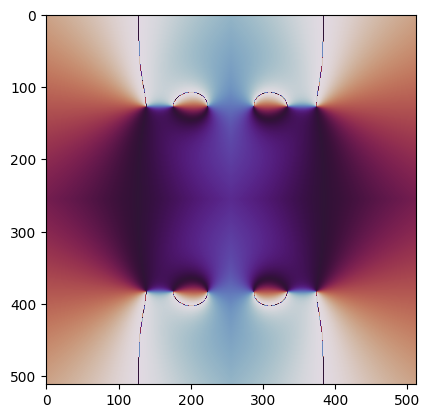

3.1
339.067790 seconds (1.22 M allocations: 7.376 GiB, 0.05% gc time, 0.58% compilation time)


In [11]:
@time begin

#check whether or not boundary conditions are periodic or not
    
n = 8
N = 2^n;
M = Int(round(N,digits = 0))
    
println(N)

rₐ = 15
fₐ = 10 .^rₐ;

angl = zeros(2N,2N)
    
LPQ = [125 250 500 1000 2000 4000 8000 16000 32000 64000]

🎱 = [5e1 5e1 5e1 5e1 5e1 0]
🏠 = [1e-2 1e-1 1e0 1e1 1e2 0]


for i ∈ 7:7
        
    cont = 0
    low = 0
    Ȧ = 0#zeros(2N,2N)

    cap = 25
    pic = 0
    poggers = 1

    #print(string(i)*" ")


    Ȧ₁ = zeros(2N,2N);
    Ȧ₂ = zeros(2N,2N);


    #🪂,σ = 1, 🎱[i];
    C₁ = zeros(2N,2N)
    C₂ = zeros(2N,2N)
    angll = 0
    #Make_Oscillon!(angll,🪂,N,σ)
    #print(angll)
        
    rstr1 = zeros(M,M)
    istr1 = zeros(M,M)
    rstr2 = zeros(M,M)
    istr2 = zeros(M,M)
    rstr3 = zeros(M,M)
    istr3 = zeros(M,M)
    rstr4 = zeros(M,M)
    istr4 = zeros(M,M)
    
    Σ = 1
    Anti_string!(rstr1,istr1,M,Σ, N/2  ,7N/8)
    Clock_string!(rstr2,istr2,M,Σ, N/2,N/8)
        
        
#     Anti_2string!(rstr1,istr1,M,Σ)
#     Clock_2string!(rstr2,istr2,M,Σ)
        
    Anti_string!(rstr3,istr3,M,Σ, N/2,7N/8)
    Clock_string!(rstr4,istr4,M,Σ, N/2,N/8)

    rstr3 = rstr3[end:-1:1,:]
    istr3 = istr3[end:-1:1,:]
    rstr4 = rstr4[end:-1:1,:]
    istr4 = istr4[end:-1:1,:]

    slot!(C₁,rstr1,Int(N/2),Int(N/2))
    slot!(C₂,istr1,Int(N/2),Int(N/2))
        
    slot!(C₁,rstr2,Int(N/2),Int(3N/2))
    slot!(C₂,istr2,Int(N/2),Int(3N/2))
        
    slot!(C₁,rstr3,Int(3N/2),Int(N/2))
    slot!(C₂,istr3,Int(3N/2),Int(N/2))
        
    slot!(C₁,rstr4,Int(3N/2),Int(3N/2))
    slot!(C₂,istr4,Int(3N/2),Int(3N/2))
        
  
        
    angler!(angl,C₁,C₂) 
        
    PyPlot.imshow(angl,vmin=-π,vmax = π,cmap = "twilight")


    s = 6
    r = 6

    


    t₁ = 0.1

    LQCD = LPQ/(2*100)*0.4

    Δx = round(LQCD[6]/N,digits = 6)
    Δt = 0.001



        
    repeat = 15
        
        
    Srun_2D!(n,N,t₁,C₁,C₂,Ȧ₁,Ȧ₂,Δx,Δt,fₐ,i,r,s,repeat,cont,low,Ȧ,angll,poggers,cap,pic)


end
    
    

end

In [12]:
@time begin


    
n = 5
N = 2^n;
M = Int(round(N,digits = 0))
    
println(N)

rₐ = 15
fₐ = 10 .^rₐ;

    
    
LPQ = [125 250 500 1000 2000 4000 8000 16000 32000 64000]

🎱 = [1e1 1e1 1e1 1e1 1e1 1e1]
🏠 = [1e-2 1e-1 1e0 1e1 1e2 0]
st = [1 5 7]


for i ∈ 1:3
        
    cont = 25
    low = 0
    Ȧ = rand(Normal(0,1e0),2N,2N)
    #Ȧ =   zeros(2N,2N)
        
    angll = ones(2N,2N)

    cap = 2
    pic = 0
    poggers = 6.68

    print(string(i)*" ")


    Ȧ₁ = zeros(2N,2N);
    Ȧ₂ = zeros(2N,2N);
    C₁ = zeros(2N,2N)
    C₂ = zeros(2N,2N)


    🪂,σ = 1, 🎱[i];

    angll1 = zeros(N,N)
    Make_Oscillon!(angll1,🪂,N,σ)
    angll2 = zeros(Int(N),Int(N))
    Make_Oscillon!(angll2,🪂,Int(N),σ)
    #print(angll)
    
        
    angll = angll * angll1[1,1]
        

    slot!(angll,angll1,Int(N),Int(N/2))
    slot!(angll,angll2,Int(N),Int(3N/2))


    s = 1
    r = 5

    
      #  save("QCDTOWN/Oscillon/Saving/Box"*string(n)*string(🥪)*string(i)*".jld", "Real", A₁,"Imaginary",A₂,"Realvel",Ȧ₁,"RealIm",Ȧ₂,"angle",angll,"AngVel",Ȧ)
    #oad("PQTOWN/new/Saving/"*string(i)*"/Box"*string(n)*string(repeat)*".jld")["Real"]

    t₁ = 1.5

    LQCD = LPQ/(2*100)*0.4

    Δx = round(LQCD[8]/N,digits = 6)
    Δt = 0.001



        
    repeat = 35
        
        
    Orun_2D!(n,N,t₁,C₁,C₂,Ȧ₁,Ȧ₂,Δx,Δt,fₐ,i,r,s,repeat,cont,low,Ȧ,angll,poggers,cap,pic)


end
    
    

end

32
1 

LoadError: InterruptException:

In [9]:
@time begin


    
n = 8
N = 2^n;
M = Int(round(N,digits = 0))
    
println(N)

rₐ = 15
fₐ = 10 .^rₐ;

    #1e0 size, 1e-6 power
    
    
LPQ = [125 250 500 1000 2000 4000 8000 16000 32000 64000]

🎱 = [1e0 1e0 1e0 1e0 5e0 1e1 1e1 1e1 5e0 5e0]
🏠 = [1e-2 1e-1 1e0 1e1 1e2 0]
st = [1 5 7 7 1 7 1 7 1 7]



for i ∈ 1:3
        
    cont = 0
    low = 0
    #Ȧ = rand(Normal(0,1e-1),N,N)
    Ȧ =   zeros(N,N)
        
    #angll = ones(N,N)

    cap = 25
    pic = 0
    poggers = 6.68

    print(string(i)*" ")


    Ȧ₁ = zeros(N,N);
    Ȧ₂ = zeros(N,N);
    C₁ = zeros(N,N)
    C₂ = zeros(N,N)


    🪂,σ = 2e0, 🎱[i];

    angll = zeros(N,N)
    Make_Oscillon!(angll,🪂,N,σ)
#     angll2 = zeros(Int(N),Int(N))
#     Make_WOscillon!(angll2,🪂,Int(N),σ)
    #print(angll)
    
        
    #angll = angll * angll1[1,1]
        

#     slot!(angll,angll1,Int(N),Int(N/2))
#     slot!(angll,angll2,Int(N),Int(3N/2))


    s = st[i]
    r = 1

    
#     angll = load("QCDTOWN/Oscillon/Saving/Box"*string(n)*string(cont)*string(i)*".jld")["angle"]
#     low = load("QCDTOWN/Oscillon/Saving/Strings"*string(n)*string(cont)*string(i)*".jld")["lo"]

#     Ȧ = load("QCDTOWN/Oscillon/Saving/Box"*string(n)*string(cont)*string(i)*".jld")["AngVel"]
    t₁ = 1.5 + cont*0.2

    LQCD = LPQ/(2*100)*0.4

    Δx = round(LQCD[7]/N,digits = 6)
    Δt = 0.001



        
    repeat = 35
        
        
    Orun_2D!(n,N,t₁,C₁,C₂,Ȧ₁,Ȧ₂,Δx,Δt,fₐ,i,r,s,repeat,cont,low,Ȧ,angll,poggers,cap,pic)


end
    
    

end

256
1 1.7
1.9
2.1
2.3
2.5
2.701
2.901
3.100306406111372
3.30001428513462
3.500584328358709
3.7004961519547193
3.9000891918471448
4.100029735330848
4.300118506850442
4.500061496021261
4.700001910074325
4.900074920859946
5.100055578082287
5.300008464119165
5.500007304110302
5.700005950385252
5.900000846341929
6.10001125387469
6.300067110491822
6.500050527438882
6.700037553956347
6.900028483328479
7.10003376122721
7.300017759357692
7.5000114475655835
7.700042902871927
7.900018511343894
8.100023852528464
8.300023546685344
8.500027158661023
2 1.7
1.9
2.1
2.3
2.5
2.701
2.901
3.100306406111372
3.30001428513462
3.500584328358709
3.7004961519547193
3.9000891918471448
4.100029735330848
4.300118506850442
4.500061496021261
4.700001910074325
4.900074920859946
5.100055578082287
5.300008464119165
5.500007304110302
5.700005950385252
5.900000846341929
6.10001125387469
6.300067110491822
6.500050527438882
6.700037553956347
6.900028483328479
7.10003376122721
7.300017759357692
7.5000114475655835
7.70004290

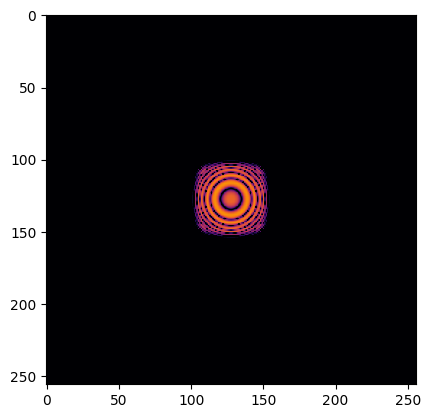

PyObject <matplotlib.image.AxesImage object at 0x7f2a1816c070>

In [12]:
  
angll = load("QCDTOWN/Oscillon/Saving/Box"*string(8)*string(35)*string(1)*".jld")["angle"]
#     low = load("QCDTOWN/Oscillon/Saving/Strings"*string(n)*string(cont)*string(i)*".jld")["lo"]

#     Ȧ = load("QCDTOWN/Oscillon/Saving/Box"*string(n)*string(cont)*string(i)*".jld")["AngVel"]



ρ = angll.^2
rho = mean(ρ)


#PyPlot.imshow(log.(ρ/rho)[103:154,103:154],vmin = 0,vmax = 4,cmap = "inferno")

PyPlot.imshow(log.(ρ/rho),vmin = 0,vmax = 6,cmap = "inferno")


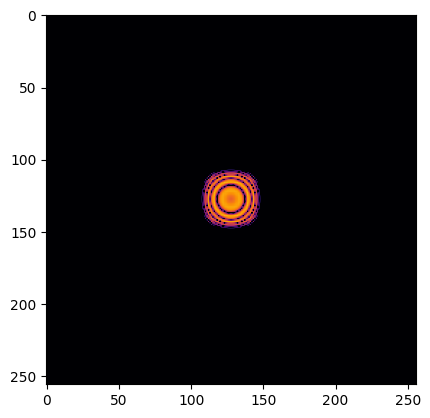

PyObject <matplotlib.image.AxesImage object at 0x7f2a181e1580>

In [13]:
angll = load("QCDTOWN/Oscillon/Saving/Box"*string(8)*string(35)*string(2)*".jld")["angle"]
#     low = load("QCDTOWN/Oscillon/Saving/Strings"*string(n)*string(cont)*string(i)*".jld")["lo"]

#     Ȧ = load("QCDTOWN/Oscillon/Saving/Box"*string(n)*string(cont)*string(i)*".jld")["AngVel"]



ρ = angll.^2
rho = mean(ρ)


#PyPlot.imshow(log.(ρ/rho)[109:148,109:148],vmin = 0,vmax = 4,cmap = "inferno")

PyPlot.imshow(log.(ρ/rho),vmin = 0,vmax = 6,cmap = "inferno")

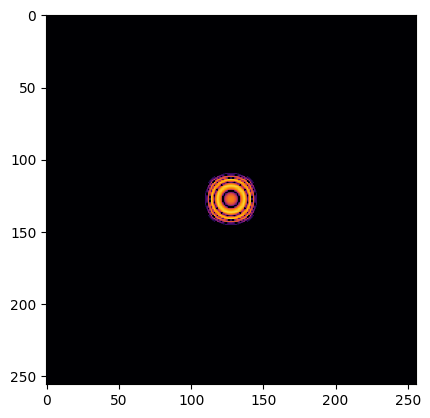

PyObject <matplotlib.image.AxesImage object at 0x7f2a18144460>

In [14]:
angll = load("QCDTOWN/Oscillon/Saving/Box"*string(8)*string(35)*string(3)*".jld")["angle"]
#     low = load("QCDTOWN/Oscillon/Saving/Strings"*string(n)*string(cont)*string(i)*".jld")["lo"]

#     Ȧ = load("QCDTOWN/Oscillon/Saving/Box"*string(n)*string(cont)*string(i)*".jld")["AngVel"]



ρ = angll.^2
rho = mean(ρ)


#PyPlot.imshow(log.(ρ/rho)[111:146,111:146],vmin = 0,vmax = 4,cmap = "inferno")


PyPlot.imshow(log.(ρ/rho),vmin = 0,vmax = 6,cmap = "inferno")

In [12]:

# save("QCDTOWN/Oscillon/Saving/Box"*string(n)*string(🥪)*string(i)*".jld", "Real", A₁,"Imaginary",A₂,"Realvel",Ȧ₁,"RealIm",Ȧ₂,"angle",angll,"AngVel",Ȧ)
# save("QCDTOWN/Oscillon/Saving/MinMax"*string(n)*string(🥪)*string(i)*".jld", "max", axionmax,"min",axionmin, "Fmax", Fmax, "Fmin", Fmin, "Fmed", Fmed)



# save("QCDTOWN/Oscillon/Saving/Strings"*string(n)*string(🥪)*string(i)*".jld","time",tracker,"number",cores,"lo",lo)
# save("QCDTOWN/Oscillon/Saving/FFT"*string(n)*string(🥪)*string(i)*".jld","saxion",saxion,"axion",axion,"axenergy",axenergy)
t = load("QCDTOWN/Oscillon/Saving/Strings9259.jld")["time"]

Fmin = load("QCDTOWN/Oscillon/Saving/MinMax9259.jld")["Fmin"]
Fmax = load("QCDTOWN/Oscillon/Saving/MinMax9259.jld")["Fmax"]
Fmed = load("QCDTOWN/Oscillon/Saving/MinMax9259.jld")["Fmed"]

Plots.plot(t,Fmin)
Plots.plot!(t,Fmax)
Plots.plot!(t,Fmed)

LoadError: DomainError with -59.064664417802156:
log will only return a complex result if called with a complex argument. Try log(Complex(x)).

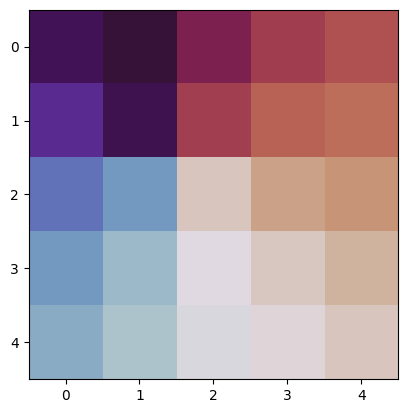

PyObject <matplotlib.image.AxesImage object at 0x7f9655ee25b0>

In [102]:
   C₁ = load("QCDTOWN/rs/Saving/1/1/1/Box910.jld")["Real"]
    C₂ = load("QCDTOWN/rs/Saving/1/1/1/Box910.jld")["Imaginary"]
    angler!(angl,C₁,C₂) 
    PyPlot.imshow(angl[436:440,96:100],vmin=-π,vmax = π,cmap = "twilight")

#             A1[22:26,215:219] = ones(5,5)
#    A2[22:26,215:219] = zeros(5,5)
#     A1[426:430,35:39] = ones(5,5)
#     A2[426:430,35:39] = zeros(5,5)
#     A1[77:81,201:205] = ones(5,5)
#     A2[77:81,201:205] = zeros(5,5)
#     A1[436:440,96:100] = ones(5,5)
#     A2[436:440,96:100] = zeros(5,5)



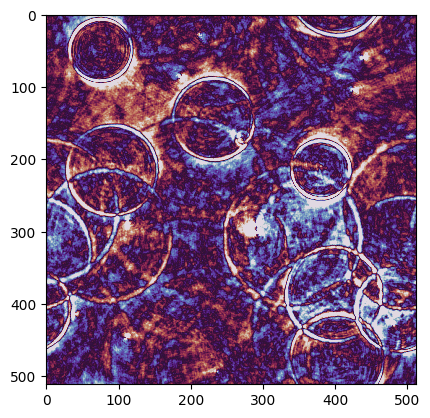

PyObject <matplotlib.image.AxesImage object at 0x7f95f9fdd970>

In [62]:
B = load("QCDTOWN/rs/Saving/1/1/1/Box910.jld")["AngVel"]

PyPlot.imshow(B,vmin=-π,vmax = π,cmap = "twilight")


In [13]:
@time begin


    
n = 9
N = 2^n;
println(N)

rₐ = 15
fₐ = 10 .^rₐ;
r = 1
s = 1
    
    
    
LPQ = [125 250 500 1000 2000 4000 8000 16000 32000 64000]
angl = zeros(N,N)
    


for i ∈ 1:1
        
    cont = 0
    low = 0
    Ȧ = 0

    cap = 1
    angll = 0
    pic = 0
    poggers = 1

    t₀ = 0.0001;
    print(string(i)*" ")


    Ȧ₁ = zeros(N,N);
    Ȧ₂ = zeros(N,N);


    μ,σ = 0, 0.1;
    C₁ = rand(Normal(μ,σ),N,N);
    C₂ = rand(Normal(μ,σ),N,N);


    Δx = round(LPQ[6]/N,digits = 4)
    Δt = 0.004
    
        

    #FPQrun_2D!(n, N, t₀, C₁, C₂, Ȧ₁, Ȧ₂, Δx, Δt,fₐ,i,repeat,cont,low)
        

    s = 1
    r = 1

    repeat = 2

    C₁ = load("QCDTOWN/Saving/5/Box9211.jld")["Real"]
    C₂ = load("QCDTOWN/Saving/5/Box9211.jld")["Imaginary"]
    
    

#     C₁ = load("PQTOWN/new/Saving/"*string(i)*"/Box"*string(n)*string(repeat)*".jld")["Real"]
#     C₂ = load("PQTOWN/new/Saving/"*string(i)*"/Box"*string(n)*string(repeat)*".jld")["Imaginary"]
#     Ȧ₁ = load("PQTOWN/new/Saving/"*string(i)*"/Box"*string(n)*string(repeat)*".jld")["Realvel"]
#     Ȧ₂ = load("PQTOWN/new/Saving/"*string(i)*"/Box"*string(n)*string(repeat)*".jld")["RealIm"]

    t₁ = 0.4

    LQCD = LPQ/(repeat*100)*0.4

    Δx = round(LQCD[6]/N,digits = 6)
    Δt = 0.001

    repeat = 2
    
    
    angler!(angl,C₁,C₂)    
        
    PyPlot.imshow(angl,vmin=-π,vmax = π,cmap = "twilight")

    Real1 = C₁[185:215,250:280]
    Im1 = C₂[185:215,250:280]
    osc1 = zeros(length(Real1[:,1]),length(Real1[1,:]))
    angler!(osc1,Real1,Im1)
    PyPlot.imshow(osc1,vmin=-π,vmax = π,cmap = "twilight")

    #FErun_2D!(n,N,t₁,C₁,C₂,Ȧ₁,Ȧ₂,Δx,Δt,fₐ,i,r,s,repeat,cont,low,Ȧ,angll,poggers,cap,pic)

    Real2 = C₁[260:290,300:330]
    Im2 = C₂[260:290,300:330]
    osc2 = zeros(length(Real2[:,1]),length(Real2[1,:]))
    angler!(osc2,Real2,Im2)
    PyPlot.imshow(osc2,vmin=-π,vmax = π,cmap = "twilight")

    A1 = rand(Normal(1,0.1),N,N);
    A2 = rand(Normal(0,0.1),N,N);
        
    A1[185:215,250:280] = Real1
    A2[185:215,250:280] = Im1
    
    A1[260:290,300:330] = Real2
    A2[260:290,300:330] = Im2
    
    
    ang = zeros(N,N)
    angler!(ang,A1,A2)
    
    PyPlot.imshow(ang,vmin=-π,vmax = π,cmap = "twilight")
        
    Ȧ₁,Ȧ₂ = zeros(N,N),zeros(N,N)
        
    Orun_2D!(n,N,t₁,A1,A2,Ȧ₁,Ȧ₂,Δx,Δt,fₐ,i,r,s,repeat,cont,low,Ȧ,angll,poggers,cap,pic)


end
    
    

end

512
1 

LoadError: InterruptException:

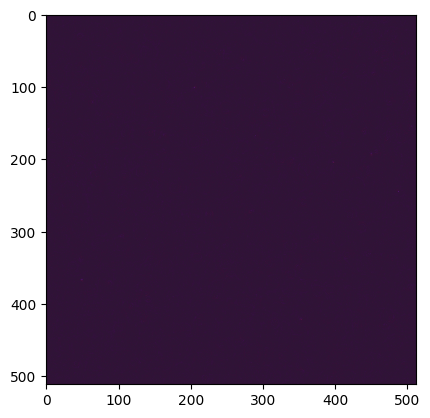

PyObject <matplotlib.image.AxesImage object at 0x7f9655e26d30>

In [21]:
B = load("QCDTOWN/Saving/5/Box9111.jld")["AngVel"]

PyPlot.imshow(B,vmin=-π,vmax = π,cmap = "twilight")

